# Ornstein Uhlenbeck process


In [1]:
from dataclasses import dataclass #???????????
from typing import Optional, Union
import numpy as np
from sklearn.linear_model import LinearRegression
#import statsmodels.api as sm #######Buscar
import brownian_motion


# ----------------------------------------------------------------
# Ornstein Uhlenbeck process

@dataclass
class OUParams:
    alpha: float  # mean reversion parameter
    gamma: float  # asymptotic mean
    beta: float  # Brownian motion scale (standard deviation)


ModuleNotFoundError: No module named 'sklearn'

In [48]:

def _get_integal_W(
    t: np.ndarray, dW: np.ndarray, OU_params: OUParams
) -> np.ndarray:
    """Integral con respecto al movimiento browniano (W), ∫=...dW."""
    exp_alpha_s = np.exp(OU_params.alpha * t)
    integral_W = np.cumsum(exp_alpha_s * dW)
    return np.insert(integral_W, 0, 0)[:-1]


def get_OU_process(
    T: int,
    OU_params: OUParams,
    X_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is amaño de la muestra.
    - Ou_params instancia dela clase OUParams.
    - X_0 valor inicial del proceso. Se toma como gamma (media asintótica) si es None
    Returns vector (convertir para que genere matrix de d procesos).
    """
    t = np.arange(T, dtype=np.longdouble) # float to avoid np.exp overflow
    exp_alpha_t = np.exp(-OU_params.alpha * t)
    dW = brownian_motion.get_dW(T, random_state) ####Aquí se cambiaría con el parám d
    integral_W = _get_integal_W(t, dW, OU_params)
    _X_0 = X_0 if X_0 is not None else OU_params.gamma
    
    return (
        _X_0 * exp_alpha_t
        + OU_params.gamma * (1 - exp_alpha_t)
        + OU_params.beta * exp_alpha_t * integral_W
    ) #Solución cerrada de la EDE.

(array([-0.008, -0.006, -0.004, -0.002,  0.   ,  0.002,  0.004,  0.006,
         0.008,  0.01 ]),
 [Text(0, -0.008, '−0.008'),
  Text(0, -0.006, '−0.006'),
  Text(0, -0.004, '−0.004'),
  Text(0, -0.002, '−0.002'),
  Text(0, 0.0, '0.000'),
  Text(0, 0.002, '0.002'),
  Text(0, 0.004, '0.004'),
  Text(0, 0.006, '0.006'),
  Text(0, 0.008, '0.008'),
  Text(0, 0.010000000000000002, '0.010')])

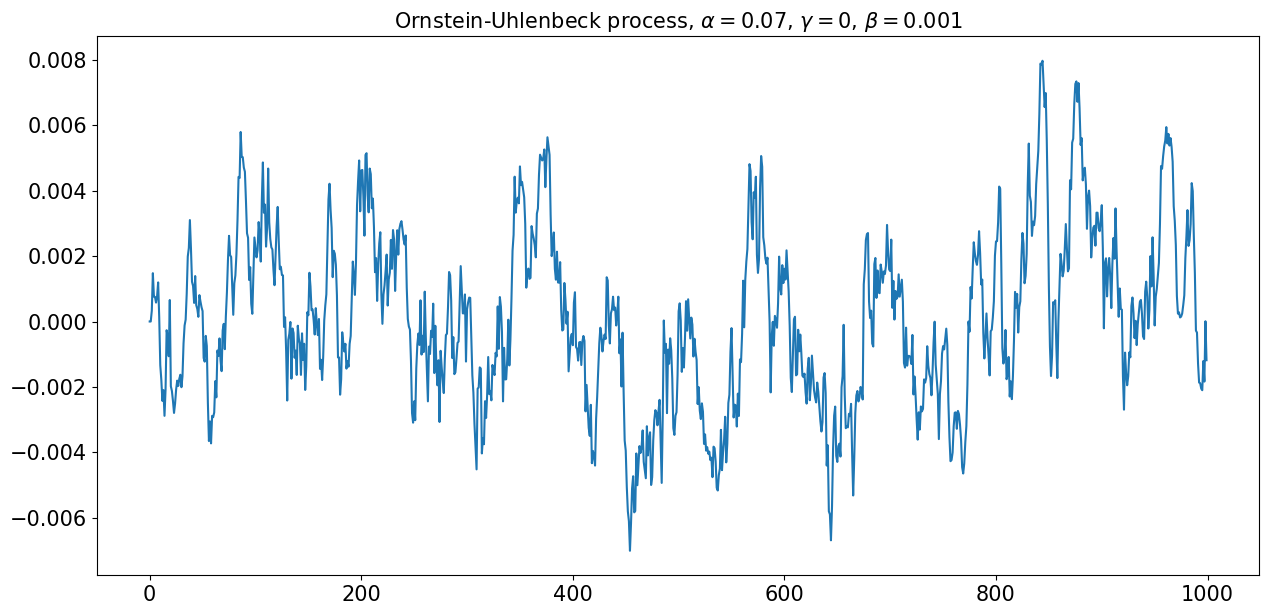

In [49]:
#import OU_proc
#from OU_proc import OUParams

OU_params = OUParams(alpha=0.07, gamma=0.0, beta=0.001)
OU_proc = get_OU_process(1_000, OU_params)

#----------------------------------------------------
# plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))

title = "Ornstein-Uhlenbeck process, "
title += r"$\alpha=0.07$, $\gamma = 0$, $\beta = 0.001$"
plt.plot(OU_proc)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [50]:
def estimate_OU_params(X_t: np.ndarray) -> OUParams:
    """
    Estimación de parámetros del proceso OU con MCO.
    X_t vector.
    Returna instancia de la clase OUParams.
    """
    y = np.diff(X_t)
    X = X_t[:-1].reshape(-1, 1)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X, y)
    # regression coeficient and constant
    alpha = -reg.coef_[0]
    gamma = reg.intercept_ / alpha
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    beta = np.std(y - y_hat)
    return OUParams(alpha, gamma, beta)

In [51]:
# generate process with random_state to reproduce results
OU_params = OUParams(alpha=0.001, gamma=0.01, beta=0.01)
OU_proc = get_OU_process(100_000, OU_params, random_state=7)

print(OU_proc)
OU_params_hat = estimate_OU_params(OU_proc)
OU_params_hat


[ 0.01        0.01        0.02688836 ... -0.15695311 -0.1495943
 -0.14865152]


OUParams(alpha=0.0011457140823235231, gamma=-0.018780028209135418, beta=0.009941351215621817)

# Procesos correlacionados

In [44]:

def get_corr_OU_procs(
    T: int,
    OU_params: Union[OUParams, tuple[OUParams, ...]],
    n_procs: Optional[int] = None,
    rho: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    Simulate correlated OU processes, correlation (rho) can be 0 or None.
    - T is the sample size of the processes.
    - OU_params can be a an instance of OUParams, in that case
        all processes have the same parameters. It can also be a tuple,
        in that case each process will have the parameters in the tuple,
        each column in the resulting 2D array corresponds to the tuple index.
    - n_procs is ignored if OU_params is tuple, else, corresponds to the number
        of processes desired. If OU_params is not tuple and n_procs is None, will
        raise ValueError.
    - rho is the correlation coefficient.
    - random_state to reproduce results.
    """
    _n_procs = _get_n_procs(OU_params, n_procs)
    corr_dWs = brownian_motion.get_corr_dW_matrix(
        T, _n_procs, rho, random_state
    )
    is_OU_params_tpl = _is_OU_params_tuple(OU_params)
    OU_procs = []
    for i in range(_n_procs):
        OU_params_i = _get_OU_params_i(OU_params, i, is_OU_params_tpl)
        dW_i = corr_dWs[:, i]
        OU_procs.append(_get_OU_process_i(T, OU_params_i, dW_i))
    return np.asarray(OU_procs).T


def _is_OU_params_tuple(
    OU_params: Union[OUParams, tuple[OUParams, ...]]
) -> bool:
    """
    Check is OU_params is a tuple of params,
    return bool.
    """
    return isinstance(OU_params, tuple)


def _get_n_procs(
    OU_params: Union[OUParams, tuple[OUParams, ...]], n_procs: Optional[int]
) -> int:
    """
    Define the number of processes, if Ou_params is a tuple the
    number of processes is the lenght of the tuple. If it is not a tuple
    then it is the "n_procs" supplied as argument,
    if it is None will raise ValueError.
    """
    if _is_OU_params_tuple(OU_params):
        return len(OU_params)  # type: ignore
    elif n_procs is None:
        raise ValueError("If OU_params is not tuple, n_procs cannot be None.")
    return n_procs


def _get_OU_params_i(
    OU_params: Union[OUParams, tuple[OUParams, ...]],
    i: int,
    is_OU_params_tpl: bool,
) -> OUParams:
    """
    Returns the ith value of the OU_params tuple if it is a tuple,
    otherwise returns OUParams.
    """
    if is_OU_params_tpl:
        return OU_params[i]  # type: ignore
    return OU_params  # type: ignore


def _get_OU_process_i(
    T: int, OU_params: OUParams, dW: np.ndarray
) -> np.ndarray:
    """
    Simulates the OU process with an external dW.
    X_0 is taken as the asymptotic mean gamma for simplicity.
    """
    t = np.arange(T, dtype=np.longdouble)  # float to avoid np.exp overflow
    exp_alpha_t = np.exp(-OU_params.alpha * t)
    integral_W = _get_integal_W(t, dW, OU_params)
    return (
        OU_params.gamma * exp_alpha_t
        + OU_params.gamma * (1 - exp_alpha_t)
        + OU_params.beta * exp_alpha_t * integral_W
    )

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4')])

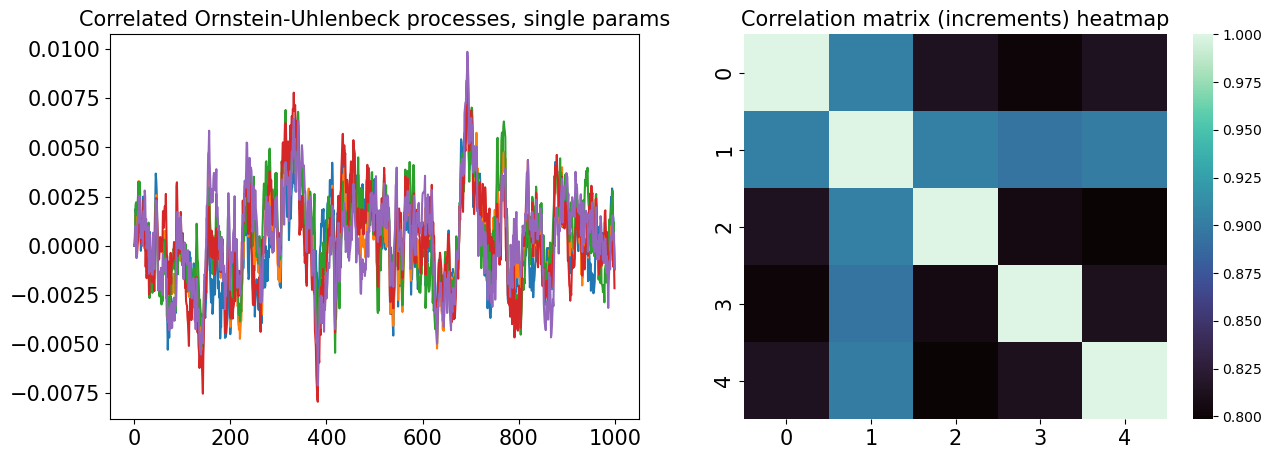

In [45]:
# case 1

T = 1_000
OU_params = OUParams(alpha=0.07, gamma=0.0, beta=0.001)
n_proc = 5
rho = 0.9
OU_procs = get_corr_OU_procs(T, OU_params, n_proc, rho)

#----------------------------------------------------
# plot
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 5))

title = "Correlated Ornstein-Uhlenbeck processes, single params"
plt.subplot(1, 2, 1)
plt.plot(OU_procs)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Correlation matrix (increments) heatmap"
plt.subplot(1, 2, 2)
sns.heatmap(np.corrcoef(np.diff(OU_procs, axis=0), rowvar=False), cmap="mako")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4')])

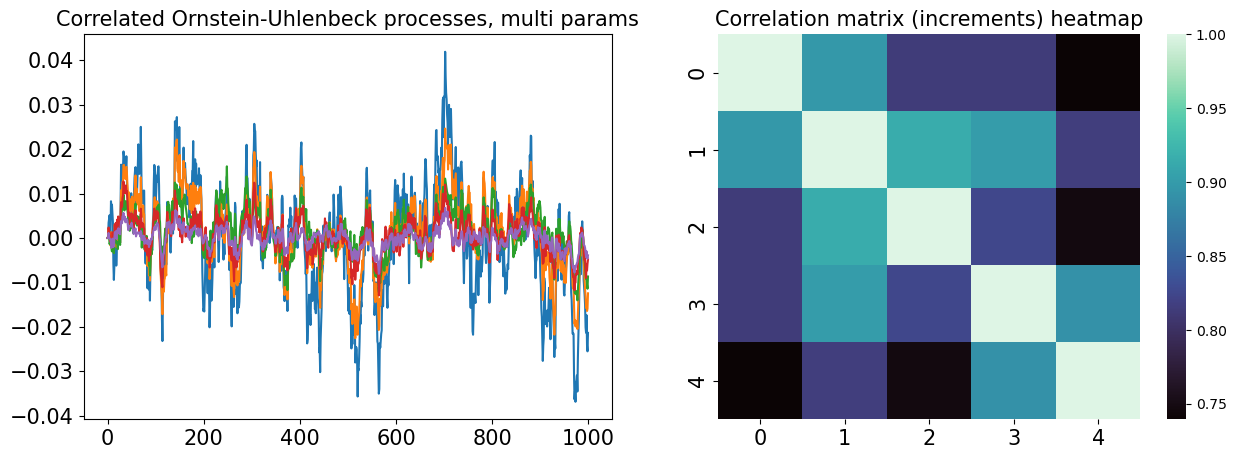

In [46]:
# case 2

T = 1_000
OU_params = (
    OUParams(alpha=0.07, gamma=0.0, beta=0.005),
    OUParams(alpha=0.05, gamma=0.0, beta=0.003),
    OUParams(alpha=0.06, gamma=0.0, beta=0.002),
    OUParams(alpha=0.09, gamma=0.0, beta=0.002),
    OUParams(alpha=0.08, gamma=0.0, beta=0.001),
)
rho = 0.9
OU_procs = get_corr_OU_procs(T, OU_params, n_proc, rho)

#----------------------------------------------------
# plot
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 5))

title = "Correlated Ornstein-Uhlenbeck processes, multi params"
plt.subplot(1, 2, 1)
plt.plot(OU_procs)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Correlation matrix (increments) heatmap"
plt.subplot(1, 2, 2)
sns.heatmap(np.corrcoef(np.diff(OU_procs, axis=0), rowvar=False), cmap="mako")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)